## General approach: 
  * Tweets: Sentences -> tokenize -> pad/truncate
  * Labels: label encoding  
  
## Bi-directional LSTM:
  * Vector Embedding layer (each word = n-dimensional vector)
  * Bi-directional LSTM with return_sequence True -> another Bi-directional LSTM
  * Dense layer with multiclass o/p

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib  inline

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nlp
import random

In [2]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


### Loading Data

In [3]:
df = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
df

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = df['train']
val = df['validation']
test = df['test']

In [6]:
print(train[0])
print(val[0]  )
print(test[0] )

{'label': 'sadness', 'text': 'i didnt feel humiliated'}
{'label': 'sadness', 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'}
{'label': 'sadness', 'text': 'im feeling rather rotten so im not very ambitious right now'}


In [7]:
len(train), len(val), len(test)

(16000, 2000, 2000)

In [8]:
def get_tweet(data):
    tweets = [row['text'] for row in data]
    labels = [row['label'] for row in data]
    return tweets, labels

In [9]:
train_tweets, train_labels = get_tweet(train)

len(train_tweets)

16000

In [10]:
train_tweets[:2], train_labels[:2]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 ['sadness', 'sadness'])

In [11]:
pd.Series(train_labels).value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
dtype: int64

### Tokenize the tweets

Keep 10,000 most frequent words in the dataset, and convert them to numerical sequence

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [13]:
tokenizer.fit_on_texts(train_tweets)

In [14]:
tokenizer.texts_to_sequences([train_tweets[0]]), train_tweets[0]

([[2, 139, 3, 679]], 'i didnt feel humiliated')

### Padding & Truncating tweets - model will need a fixed shape

Reviewing the histogram of tweet lengths to determine an appropriate maximum length, which captures most of the data, while taking care of tail distribution. Bring the dataset to a uniform shape, by truncating/ padding individual tweets to comply with the maximum length selected.

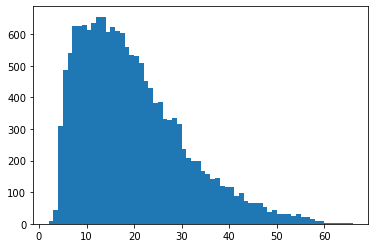

In [15]:
lengths = [len(t.split(' ')) for t in train_tweets]

plt.hist(lengths, bins=len(set(lengths)));

In [16]:
maxlen = 50

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [17]:
train_padded_seq = get_sequences(tokenizer, train_tweets)
train_padded_seq.shape

(16000, 50)

In [18]:
print(train_tweets[0])
print(train_padded_seq[0])

i didnt feel humiliated
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [19]:
print(train_tweets[1])
print(train_padded_seq[1])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[   2   40  101   60    8   15  494    5   15 3496  553   32   60   61
  128  148   76 1480    4   22 1255    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Preparing Labels - converting tweet emotion from 'text' to 'numerical' value

In [20]:
train_labels[0:5]

['sadness', 'sadness', 'anger', 'love', 'anger']

In [21]:
set(train_labels)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

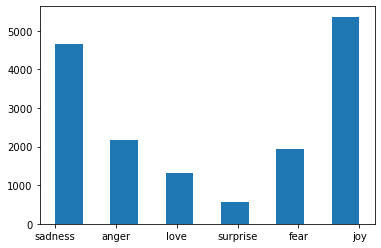

In [22]:
plt.hist(train_labels, bins=11);

In [23]:
class_to_index = dict((emo, i) for i, emo in enumerate(set(train_labels)))
print(class_to_index)

index_to_class = dict((i, emo) for emo, i in class_to_index.items())
print(index_to_class)

{'fear': 0, 'joy': 1, 'love': 2, 'anger': 3, 'surprise': 4, 'sadness': 5}
{0: 'fear', 1: 'joy', 2: 'love', 3: 'anger', 4: 'surprise', 5: 'sadness'}


In [24]:
train_labels_class = np.array([class_to_index[x] for x in train_labels])

In [25]:
train_labels_class[0:5], train_labels[0:5]

(array([5, 5, 3, 2, 3]), ['sadness', 'sadness', 'anger', 'love', 'anger'])

### TensorFlow Model 

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),     # output will be 50 vectors of 16 dimensions each
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), # Bidirectional wrapper for LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [27]:
# Embedding Layer - turns positive integers (indexes) into dense vectors of fixed size.
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    # input_dim: size of the vocabulary in the text data
    # output_dim: size of the vector space in which words will be embedded
    # input_length: length of input sequences
    # The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words
    
# Bidirectional Layer
# https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    # Bidirectional LSTMs train two LSTMs on the input sequence - first on as-is and second on a reversed copy
    # return_sequences - every time-step there will be an output

In [28]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Model Training

#### Prepping Validation dataset

In [30]:
def prep_data(df):
    df_tweets, df_labels = get_tweet(df)
    df_padded_seq = get_sequences(tokenizer, df_tweets)
    df_labels_class = np.array([class_to_index[x] for x in df_labels])
    return df_padded_seq, df_labels_class

In [31]:
val_padded_seq, val_labels_class = prep_data(val)

In [32]:
print(val[0], '\n', 
      val_padded_seq[0],'\n', 
      val_labels_class[0])

{'label': 'sadness', 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'} 
 [ 17   8 157 260   4 343  16  51  19 212   1  50  10  13 533   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 
 5


#### Training Model

In [33]:
print(train_padded_seq.shape, train_labels_class.shape)

(16000, 50) (16000,)


In [34]:
h = model.fit(train_padded_seq, train_labels_class,
              validation_data=(val_padded_seq, val_labels_class),
              epochs=20, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
             )

Epoch 1/20
500/500 [==============================] - 12s 19ms/step - loss: 1.3265 - accuracy: 0.4693 - val_loss: 0.8029 - val_accuracy: 0.7010
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4978 - accuracy: 0.8306 - val_loss: 0.4824 - val_accuracy: 0.8395
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2398 - accuracy: 0.9249 - val_loss: 0.3635 - val_accuracy: 0.8875
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1520 - accuracy: 0.9526 - val_loss: 0.4012 - val_accuracy: 0.8740
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1123 - accuracy: 0.9643 - val_loss: 0.3893 - val_accuracy: 0.8820
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.0845 - accuracy: 0.9731 - val_loss: 0.3711 - val_accuracy: 0.8800
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.0671 - accuracy: 0.9790 - val_loss: 0.3971 - val_accuracy: 0.884

In [35]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

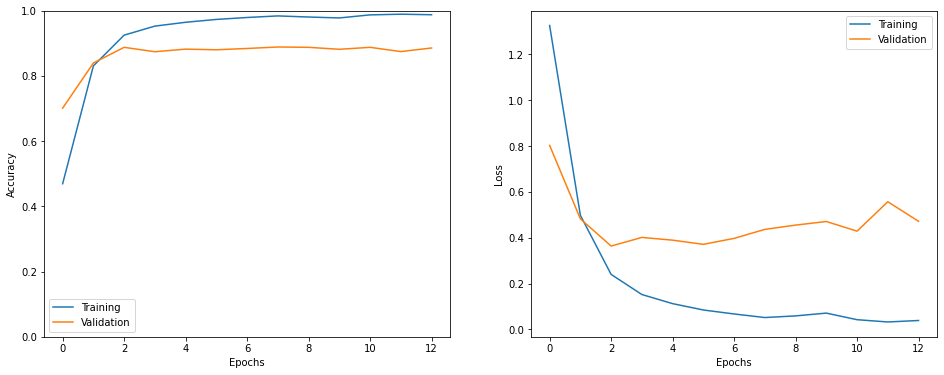

In [36]:
show_history(h)

### Performance on Test set

In [37]:
test_padded_seq, test_labels_class = prep_data(test)

In [38]:
_ = model.evaluate(test_padded_seq, test_labels_class)

63/63 [==============================] - 0s 5ms/step - loss: 0.4557 - accuracy: 0.8845


#### Checking one random example

In [39]:
# Checking particular instance:
i = random.randint(0, len(test)-1)

print('Tweet: ', test['text'][i])
print('Class: ', test['label'][i])

Tweet:  ive got a off sale the ad says starting tomorrow but im feeling generous and started it now
Class:  love


In [40]:
# Fixing shape of input for model prediction
print( test_padded_seq[i].shape )
print( test_padded_seq[i] )

# Insert a new axis that will appear at the `axis` position in the expanded array shape.
print( np.expand_dims(test_padded_seq[i], axis=0).shape )
print( np.expand_dims(test_padded_seq[i], axis=0) ) 

(50,)
[  73  141    7  169 3615    6 2630 1027  316  972   19   17    8  342
    4  198   13   58    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(1, 50)
[[  73  141    7  169 3615    6 2630 1027  316  972   19   17    8  342
     4  198   13   58    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [41]:
model.predict(np.expand_dims(test_padded_seq[i], axis=0))

array([[2.11305291e-04, 1.00238465e-01, 8.92853737e-01, 3.58444580e-04,
        6.06834237e-03, 2.69747572e-04]], dtype=float32)

In [42]:
p = model.predict(np.expand_dims(test_padded_seq[i], axis=0))[0]

In [43]:
print('Prediction Class: ',index_to_class[p.argmax()])

Prediction Class:  love


#### Confusion Matrix

In [44]:
y_pred = model.predict(test_padded_seq)
y_class = [i.argmax() for i in y_pred]

In [45]:
confusion_matrix(test_labels_class, y_class)

array([[188,   5,   0,   8,   8,  15],
       [  2, 640,  36,   6,   5,   6],
       [  1,  30, 116,   6,   0,   6],
       [  6,   8,   0, 240,   0,  21],
       [ 17,   4,   0,   0,  44,   1],
       [  5,  22,   1,  12,   0, 541]], dtype=int64)

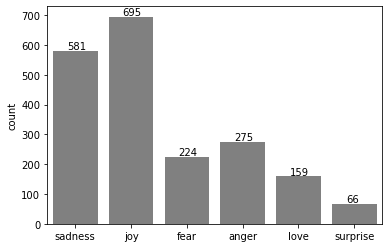

In [46]:
ax = sns.countplot(x=test['label'], color='grey')

for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+5))

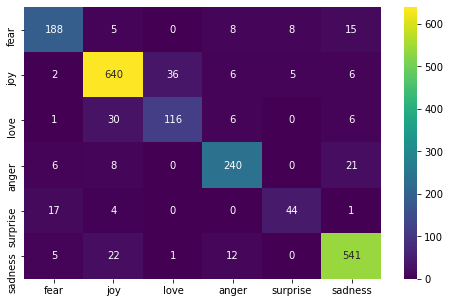

In [47]:
plt.figure(figsize=(8,5))
# sns.heatmap(confusion_matrix(test_labels_class, y_class, normalize='true'), annot=True, fmt='.2f', cmap='viridis')
sns.heatmap(confusion_matrix(test_labels_class, y_class), annot=True, fmt='.0f', cmap='viridis')
plt.xticks(ticks=np.array(range(6))+0.5, labels=class_to_index.keys())
plt.yticks(ticks=np.array(range(6))+0.5, labels=class_to_index.keys())
plt.show()

In [48]:
print(classification_report(test_labels_class, y_class))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       224
           1       0.90      0.92      0.91       695
           2       0.76      0.73      0.74       159
           3       0.88      0.87      0.88       275
           4       0.77      0.67      0.72        66
           5       0.92      0.93      0.92       581

    accuracy                           0.88      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000



The End